In [16]:
from util import *
import os, shutil
import pandas as pd

from opmap.videoData import VideoData
from opmap.vmemMap import VmemMap
from opmap.phaseMap import PhaseMap
from opmap.phaseVarianceMap import PhaseVarianceMap
from elecpy.elecpySession import ElecpySession

from elecpy.cell.luorudy.const import const_d

%matplotlib inline


In [17]:
src_dir = '/mnt/recordings/SimulationResult/'
save_dir = '/mnt/recordings/AnalysisResult/Tomii/2018-08-07/'
print(save_dir)
if not os.path.exists(save_dir) : os.mkdir(save_dir)

/mnt/recordings/AnalysisResult/Tomii/2018-08-07/


In [29]:
df = pd.read_csv('data.lr.ina.roi.csv')
df

,sim_id,x_min,x_max,y_min,y_max,f_min,f_max,description
0,20180820-1,90,130,80,120,1900,2900,pivot(20180806-1)
1,20180820-2,73,113,115,155,1300,2300,shift(20180809-6)
2,20180820-3,47,87,99,139,1300,2200,drift(20180816-6)
3,20180820-4,67,107,79,119,100,900,jump(20180817-6)
4,20180820-4,134,174,65,105,1000,2800,jump(20180817-6)


/mnt/recordings/AnalysisResult/Tomii/2018-08-07/20180820-1/x90-130_y80-120_f1900-2900
('cell/ina', 4001, 4001)
('cell/nai', 4001, 4001)
('cell/m', 4001, 4001)
('cell/h', 4001, 4001)
('cell/j', 4001, 4001)
/mnt/recordings/AnalysisResult/Tomii/2018-08-07/20180820-2/x73-113_y115-155_f1300-2300
('cell/ina', 4001, 4001)
('cell/nai', 4001, 4001)
('cell/m', 4001, 4001)
('cell/h', 4001, 4001)
('cell/j', 4001, 4001)
/mnt/recordings/AnalysisResult/Tomii/2018-08-07/20180820-3/x47-87_y99-139_f1300-2200
('cell/ina', 3501, 3501)
('cell/nai', 3501, 3501)
('cell/m', 3501, 3501)
('cell/h', 3501, 3501)
('cell/j', 3501, 3501)
/mnt/recordings/AnalysisResult/Tomii/2018-08-07/20180820-4/x67-107_y79-119_f100-900
('cell/ina', 4001, 4001)
('cell/nai', 4001, 4001)
('cell/m', 4001, 4001)
('cell/h', 4001, 4001)
('cell/j', 4001, 4001)
/mnt/recordings/AnalysisResult/Tomii/2018-08-07/20180820-4/x134-174_y65-105_f1000-2800
('cell/ina', 4001, 4001)
('cell/nai', 4001, 4001)
('cell/m', 4001, 4001)
('cell/h', 4001, 4001)

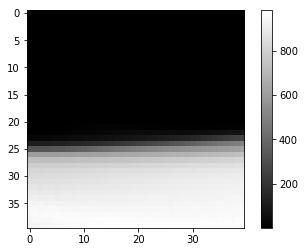

In [36]:
for i, row in df.iterrows():
    
    #if not i in [3]: continue
    
    dst_dir = os.path.join(save_dir, '{0}'.format(row['sim_id']))
    dst_dir = os.path.join(dst_dir, 'x{0}-{1}_y{2}-{3}_f{4}-{5}'.format(
        row.x_min,row.x_max,
        row.y_min,row.y_max,
        row.f_min,row.f_max,
    ))
    print(dst_dir)
    #if os.path.exists(dst_dir) : shutil.rmtree(dst_dir)
    if not os.path.exists(dst_dir) : os.makedirs(dst_dir)
        
    sess = ElecpySession(src_dir+row.sim_id, keys=['vmem', 'cell/ina'])
    sess.setRange(
        x_min = row.x_min,
        x_max = row.x_max,
        y_min = row.y_min,
        y_max = row.y_max,
        f_min = row.f_min,
        f_max = row.f_max
    )
        
    ### Sodium current integral ###
    
    xina = abs(np.sum(sess.data["cell/ina"], axis=0))
    plt.clf()
    plt.imshow(xina, cmap='gray')
    plt.colorbar()
    plt.savefig(os.path.join(dst_dir, 'xina.png'))
    
        
    ### Plot multiple status ###
    
    sess = ElecpySession(src_dir+row.sim_id, keys=['vmem','cell/nai', 'cell/m', 'cell/h', 'cell/j'])
    sess.setRange(
        x_min = row.x_min,
        x_max = row.x_max,
        y_min = row.y_min,
        y_max = row.y_max,
        f_min = row.f_min,
        f_max = row.f_max
    )
    
    outdir = os.path.join(dst_dir, 'states')
    if not os.path.exists(outdir): os.makedirs(outdir)

    h = sess.data['cell/h']
    j = sess.data['cell/j']
    m = sess.data['cell/m']
    vmem = sess.data['vmem']
    ena = ( const_d['R_'] * const_d['temp_'] / const_d['frdy_'] ) * np.log(const_d['nao_'] / sess.data['cell/nai'])

    p = h*j
    q = m**3
    r = vmem-ena
    s = -p*q*r

    for f in range(0, len(vmem), 10):


        plt.figure(figsize=(10,10))

        plt.subplot(231)
        plt.imshow(vmem[f,:,:], cmap='gray', vmax=vmem.max(), vmin=vmem.min())
        plt.title('vm')

        plt.subplot(232)
        plt.imshow(p[f,:,:], cmap='gray', vmax=p.max(), vmin=p.min())
        plt.title('hj')

        plt.subplot(233)
        plt.imshow(q[f,:,:], cmap='gray', vmax=q.max(), vmin=q.min())
        plt.title('m^3')

        plt.subplot(234)
        plt.imshow((p*q)[f,:,:], cmap='gray', vmax=(p*q).max(), vmin=(p*q).min())
        plt.title('hjm^3')

        plt.subplot(235)
        plt.imshow(r[f,:,:], cmap='gray', vmax=r.max(), vmin=r.min())
        plt.title('vm-ena')

        plt.subplot(236)
        plt.imshow(np.sum(s[:f,:,:],axis=0), cmap='gray', vmax=s.max(), vmin=s.min())
        plt.title('Ina sum')

        plt.suptitle('Frame {0:0>4}'.format(f))

        plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)

        #plt.show()
        plt.savefig(os.path.join( outdir, '{0:0>4}.png'.format(f) ))
        plt.close()